# Pytorch Workflow

In [34]:
import torch
from torch import nn #nn contains all Pytorch's building blocks for neural networks
import matplotlib.pyplot as plt


torch.__version__

'2.0.0+cu118'

## Prepare and Load data
excel, imgs, video, audio, text, whatever

We can separate machine learning into two big categories:
1. Get data into a numerical represintation.
2. Build a model to learn patterns in that numerical repr.

Lets start with a linear regression: we'll use linear regression to create the data with known parameters (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using gradient descent.

In [35]:
# Create *known parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
# input
X = torch.arange(start, end, step).unsqueeze(dim=1)
# output
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [36]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets(one of the most important concepts in ML)

In [37]:
# Create test and training sets

# first lets create percentage of data split

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [38]:
# plot (vizualise) our training data

def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None
                    ):
  """
  Plots training and test data, compares predictions
  """
  plt.figure(figsize=(7, 7))

  # plot training data in blue color
  plt.scatter(train_data, train_labels, c='b', s=10, label='Training Data')

  # plot test data in green
  plt.scatter(test_data, test_labels, c='g', s=10, label='Testing Data')

  # are there any predictions?
  if predictions is not None:
    # plot them against our test data if exist
    plt.scatter(test_data, predictions, c='r', s=10, label='Predictions')

  # show the legens
  plt.legend(prop={'size': 14})

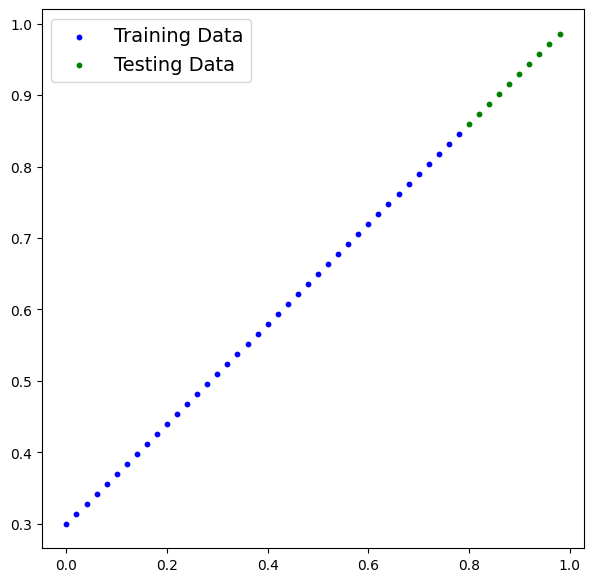

In [39]:
plot_predictions()

## Building first PyTorch model

In [40]:
# Create liner regression model class

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.rand(1,  # -> nn.Parameter <- tensor, which is to be considered as module parameter, will appear in ~Module.parameters iterator
                                          requires_grad=True, # <- default1
                                          dtype=torch.float
                                          ))
    self.bias = nn.Parameter(torch.rand(1,
                                          requires_grad=True,
                                          dtype=torch.float
                                          ))
  # Forward mwthod to de4fine a computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # x - input(training) data
    return self.weight * x + self.bias  #this is the linear regression formula

Whatthis model does:
* Start with random values (weight and bias)
* Look at training data and adjust the random numbers to get closer(or better represent) to ideal values ( the weight and bias values we used to create a data) 

How does it do so?
Trough two main algorithms:
1. Gradient descent: https://www.youtube.com/watch?v=IHZwWFHWa-w

2. Backpropagation: https://www.youtube.com/watch?v=Ilg3gGewQ5U

Оба этих алгоритма уже написаны в pytorch и будут выполнены за меня, но все равно нужно знать как они работают!

### Checking the contents of our PyTorch model

check parameters with `.parameters()`

In [41]:
# Create a random seed (для наглядности)
torch.manual_seed(88)

# Create an instance of our model
model_0 = LinearRegressionModel()

model_0.parameters() #returns a generator

for i in model_0.parameters():
  print(i)

Parameter containing:
tensor([0.7731], requires_grad=True)
Parameter containing:
tensor([0.6937], requires_grad=True)


In [42]:
# List named params
model_0.state_dict()

OrderedDict([('weight', tensor([0.7731])), ('bias', tensor([0.6937]))])

### Making predictions using torch.inference_mode()

чтобы посмотреть как хорошо наша модель предугадывает что-либо, посмотрим как хорошо она предугадает y_test основываясь на X_test

Когда мы скармливаем данные моделе, она прогоняет их через forward() метод


In [43]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [44]:
# Make predictions with model, inference_mode() не возвращает градиент в отличие от метода ниже, к тому же делает код быстрее
with torch.inference_mode(): 
  y_preds = model_0(X_test)

y_preds

# другой способ:
# y_preds = model_0(X_test)

tensor([[1.3122],
        [1.3277],
        [1.3431],
        [1.3586],
        [1.3740],
        [1.3895],
        [1.4050],
        [1.4204],
        [1.4359],
        [1.4514]])

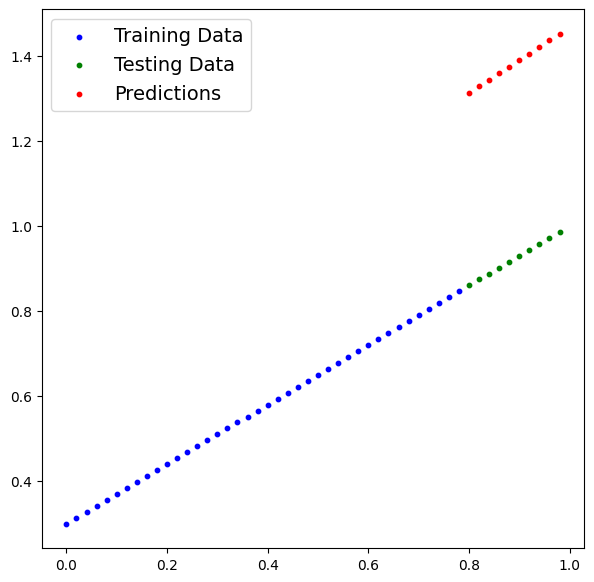

In [45]:
plot_predictions(predictions=y_preds)

In [46]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.7731])), ('bias', tensor([0.6937]))])

For our problem, since we're predicting a number, let's use MAE (which is under torch.nn.L1Loss()) in PyTorch as our loss function.

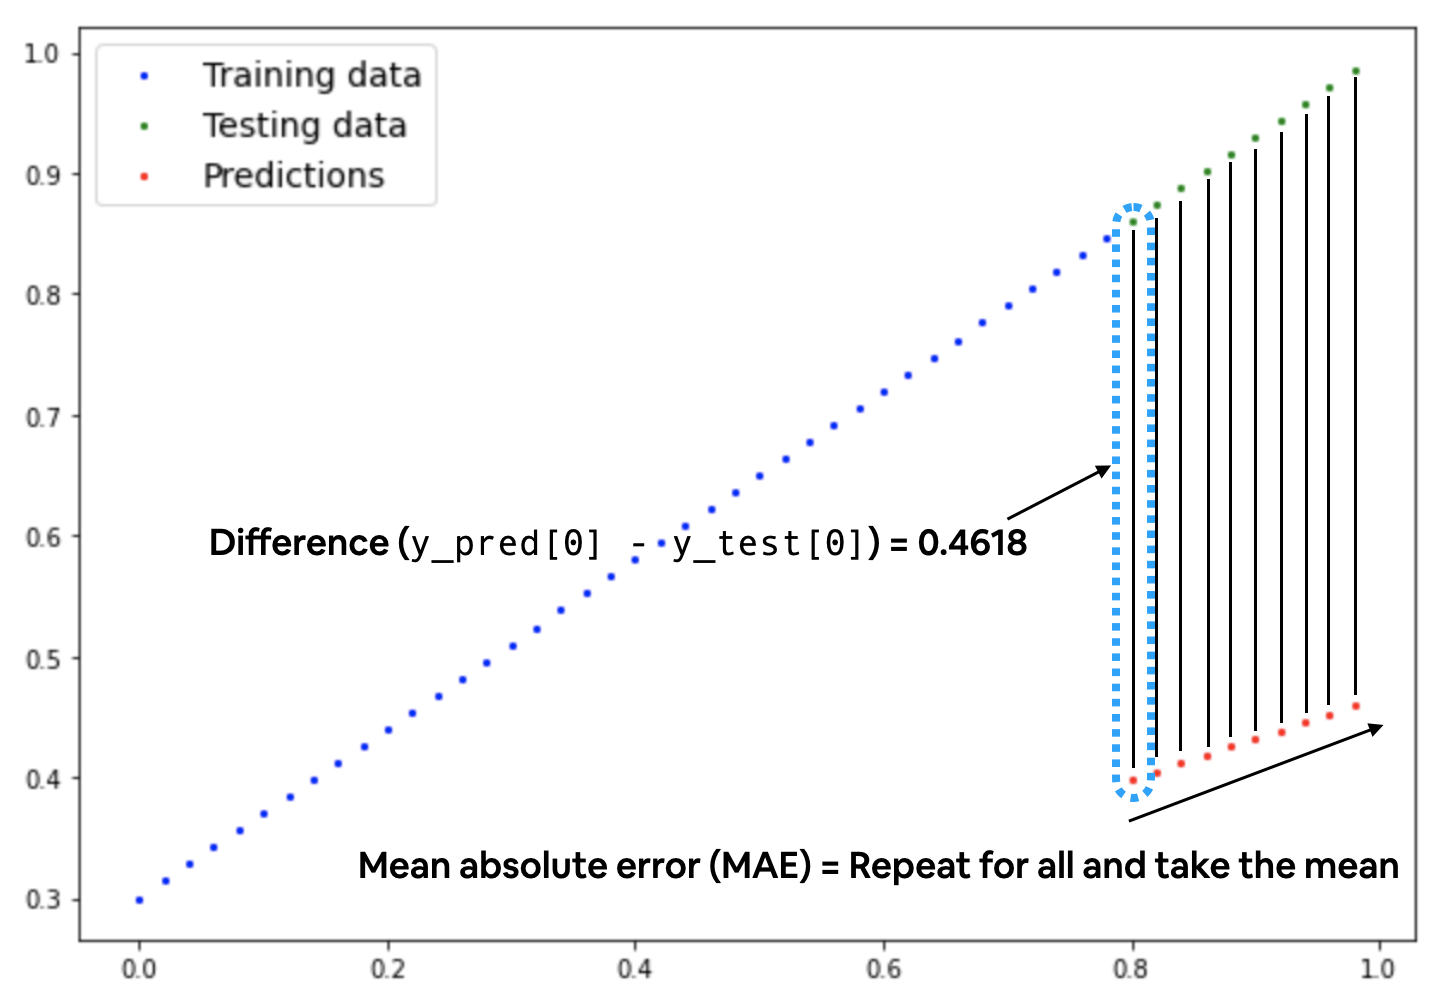

То есть просто найдем разницу между желаемым результатом и получившимся для каждой из точек

In [47]:
# Setup a loss function
loss_func = nn.L1Loss()

# Setup optimizer, there are many, most popular - SGD, Adam... etc юзаем SGD
# stochastic(random) gradient descent, потихоньку рандомно подгоняет значения и, когда находит значения, которые минимизируют loss function, продолжит подправлять в том же направлении
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01, #learning rate = probably most important hyperparameter you can set/ the more lr - the more parameters are adjusted in one epoch - 1 iter
                            )

### Building training and testing loop in python

What we need:
* **Loop trough the data**

* **Forward pass(forward propagation)** (moving data through layers, using our model's `forward()` method to make predictions on data)

* **Calculate the loss** (compare forward pass predictions to ground truth labels)

* **Optimizer zero grad**

* **Loss backward** - move backwards through network to calculate the fradients of each params of our model with respect to the loss

* **Optimizer step (gradient descent)** - use thr optimizer to adjust our model's parameters to try and improve the loss, try to make gradient =0

In [48]:
#  epoch is one loop through the  (hyperparameter(set ourselves))
epochs = 200
loss_func = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.008, #learning rate = probably most important hyperparameter you can set/ the more lr - the more parameters are adjusted in one epoch - 1 iter
                            )

# Track important values:
epoch_count = []
loss_values = []
test_loss_values = []


# Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in Ptorch sets all parameters that require gradients to require gradients, lel (gradient = slope = )

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss (input-target)
  loss = loss_func(y_pred, y_train)

  # 3. Optimize zero grad
  optimizer.zero_grad()

  # 4. Prtform backpropagation on the loss with the respect to the params of the model
  loss.backward()

  # 5. Perform gradient descent
  optimizer.step() # by default how the optimizer changes will accumulate through the loop... so we need to zero them in step 3 for the nex iter

  ### Testing - so working with testing data
  model_0.eval() # mode that turns off some settings in the model not needed for eval/testing (dropout/ batch norm layers)

  # Turns off gradient tracking
  with torch.inference_mode(): 
    # 1. Do forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss (test loss)
    test_loss = loss_func(test_pred, y_test)

  # print what is happening and append
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)

    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.42223960161209106 | Test loss: 0.44799724221229553
OrderedDict([('weight', tensor([0.7699])), ('bias', tensor([0.6857]))])
Epoch: 10 | Loss: 0.33007141947746277 | Test loss: 0.34022900462150574
OrderedDict([('weight', tensor([0.7387])), ('bias', tensor([0.6057]))])
Epoch: 20 | Loss: 0.23790326714515686 | Test loss: 0.2324608564376831
OrderedDict([('weight', tensor([0.7075])), ('bias', tensor([0.5257]))])
Epoch: 30 | Loss: 0.1457352340221405 | Test loss: 0.12469284236431122
OrderedDict([('weight', tensor([0.6763])), ('bias', tensor([0.4457]))])
Epoch: 40 | Loss: 0.053567368537187576 | Test loss: 0.016924947500228882
OrderedDict([('weight', tensor([0.6451])), ('bias', tensor([0.3657]))])
Epoch: 50 | Loss: 0.012477170675992966 | Test loss: 0.028108816593885422
OrderedDict([('weight', tensor([0.6395])), ('bias', tensor([0.3257]))])
Epoch: 60 | Loss: 0.009716818109154701 | Test loss: 0.022040480747818947
OrderedDict([('weight', tensor([0.6531])), ('bias', tensor([0.3197])

In [49]:
import numpy as np

epoch_count, np.array(torch.tensor(loss_values).numpy()), test_loss_values

([0,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190],
 array([0.4222396 , 0.33007142, 0.23790327, 0.14573523, 0.05356737,
        0.01247717, 0.00971682, 0.00696577, 0.00422229, 0.00147422,
        0.00395246, 0.00395246, 0.00395246, 0.00395246, 0.00395246,
        0.00395246, 0.00395246, 0.00395246, 0.00395246, 0.00395246],
       dtype=float32),
 [tensor(0.4480),
  tensor(0.3402),
  tensor(0.2325),
  tensor(0.1247),
  tensor(0.0169),
  tensor(0.0281),
  tensor(0.0220),
  tensor(0.0154),
  tensor(0.0094),
  tensor(0.0022),
  tensor(0.0041),
  tensor(0.0041),
  tensor(0.0041),
  tensor(0.0041),
  tensor(0.0041),
  tensor(0.0041),
  tensor(0.0041),
  tensor(0.0041),
  tensor(0.0041),
  tensor(0.0041)])

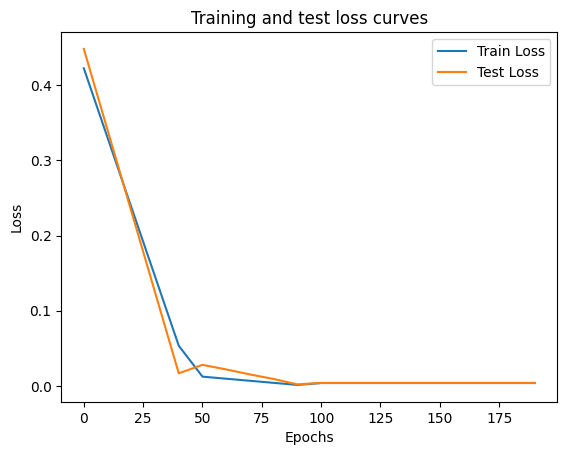

In [50]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label='Train Loss')
plt.plot(epoch_count, test_loss_values, label='Test Loss')
plt.title('Training and test loss curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

In [51]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

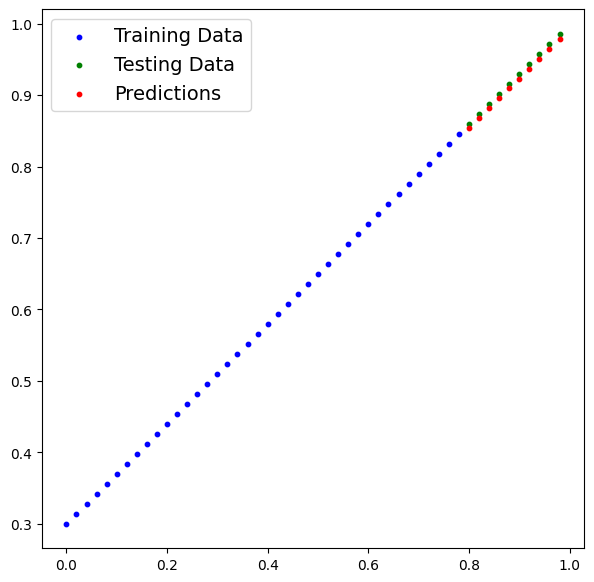

In [52]:
plot_predictions(predictions=y_preds_new)

In [53]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6946])), ('bias', tensor([0.2981]))])

## Saving and loading a model in PyTorch

Three main methods for saving and loading model in PyTTorch:

1. `torch.save()` allows you to save a PyTorch object in Python's pickle format (serializing)
2. `torch.load()` allows you to load a saved pyTorch obj. (deserializing)
3. `torch.mm.Module.load_state_dict()` allows you to load model's saved state dict.

https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [54]:
from pathlib import Path

# 1 Create model's directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2 Create model save path
MODEL_NAME = '00_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/00_pytorch_workflow_model_0.pth')

In [55]:
# Saving state dict of our model(well, almost the model itself)
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

In [56]:
# loading PyTorch model
# since we save our model's state_dict, we can create a new instance of our model class
# and load this state_dict data into model instance

loaded_model_0 = LinearRegressionModel()

# now load the data
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model_0.eval()

loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.6946])), ('bias', tensor([0.2981]))])

In [57]:
# make some predictions
with torch.inference_mode():
  loaded_y_preds = loaded_model_0(X_test)

loaded_y_preds

tensor([[0.8538],
        [0.8677],
        [0.8816],
        [0.8955],
        [0.9094],
        [0.9233],
        [0.9372],
        [0.9511],
        [0.9650],
        [0.9789]])

In [58]:
# compare loaded with original preds
y_preds_new == loaded_y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# Puting it all together!

## Data

In [59]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn


# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias 
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

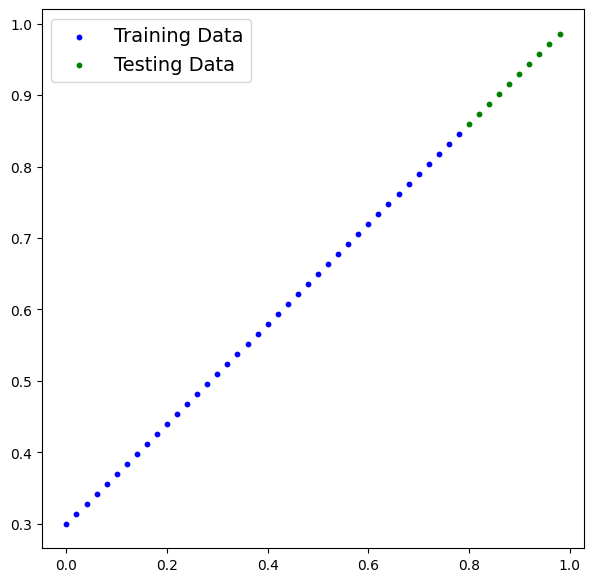

In [60]:
# Split the data

train_split = int(len(X) * 0.8)
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

# plot this data (this function is written way far above :D)
plot_predictions(X_train, y_train, X_test, y_test)

## Building model

In [72]:
# creating a linear regression model
class MyModel(nn.Module):
  def __init__(self):
    super().__init__()
  
  # Use nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features=1, 
                                  out_features=1)
    
  # Define the forward computation (input data x flows through nn.Linear())
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Another way
  #   self.weight = nn.Parameter(1)
  #   self.bias = nn.Parameter(1)
  # def forward(self, x: torch.Tensor):
  #   return self.weight * x + self.bias

In [73]:
# instanciate the model class
torch.manual_seed(42)
model_1 = MyModel()

model_1, model_1.state_dict()

(MyModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [74]:
#  Now lets put the model on GPU if any
device = "cuda" if torch.cuda.is_available() else "cpu"
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

## Training

In [75]:
# Create loss function
loss_func = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01)

In [76]:
torch.manual_seed(42)

# Set the number of epochs 
epochs = 1000 

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_func(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)

    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_func(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882


In [77]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:\n")
print(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')), ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


## making predictions

In [78]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

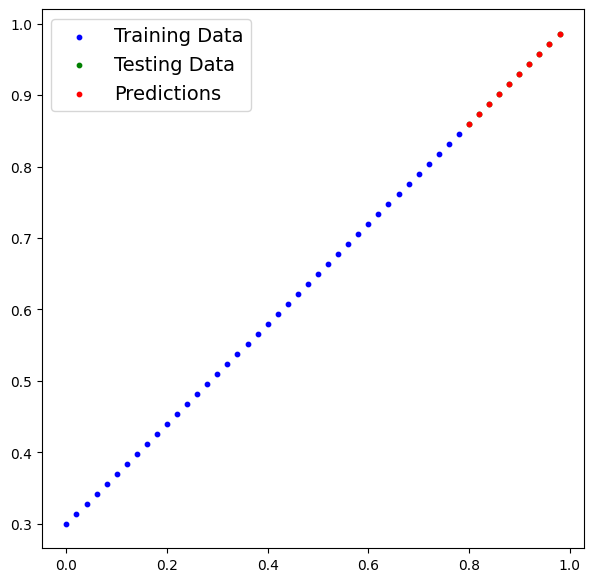

In [79]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())

## SAving and loading model

In [80]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "00_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/00_pytorch_workflow_model_1.pth


In [81]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = MyModel()

# Load model state dict 
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
MyModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


In [82]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')